In [22]:
import GenerateHalo
from GenerateHalo import *
import GenerateCluster
from GenerateCluster import *
import visualization
from visualization import *
import input_output as io
from input_output import *

import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import pandas as pd

What this notebook currently does: 
- Generates a flat redshift and M500 distribution 
- Saves the mass and redshift distribution as a .txt file

What this notebook could do, but currently doesn't:
- Save m, z dist as .csv with pd header
- Generates a realistic z, M500 distribution from a given cosmology 

What the modules could be improved to do:
- Streamline the generation of z,M500 distributions by creating a function with options
- Save the z, M500 distribution at the function level in GenerateHalo.py


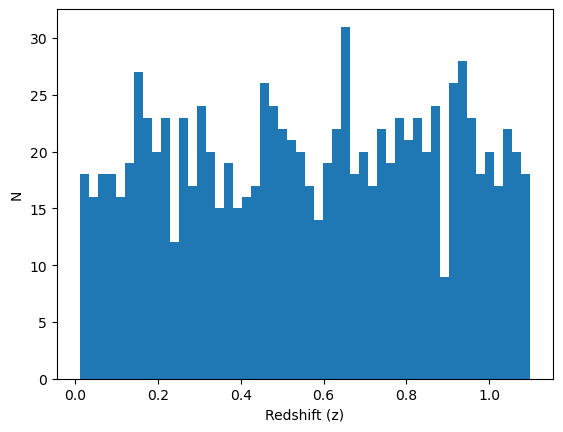

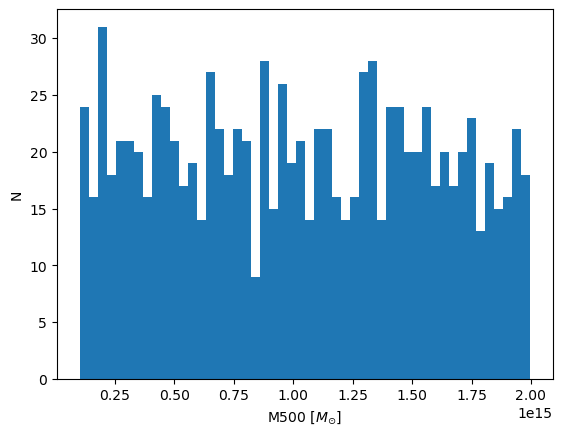

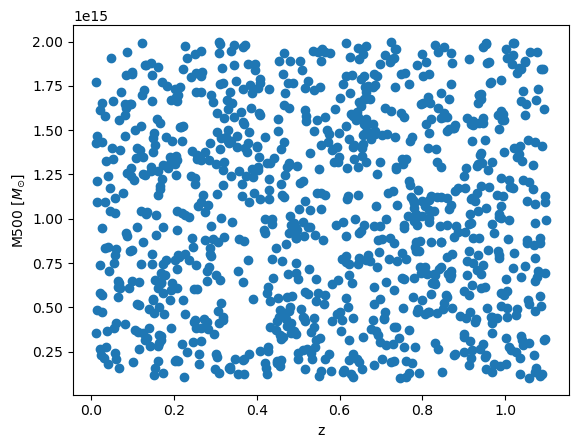

In [14]:
nsources=1000 #Number of halos to generate
zdist,mdist=GenerateHalo.flatdist_halo(0.01,1.1,1e14,2e15,nsources) #Generate a flat z, M500 distribution for sims

plt.hist(zdist,bins=50) #Show the z distribution 
plt.ylabel('N'),plt.xlabel('Redshift (z)')
plt.show()
plt.hist(mdist,bins=50) #Show the M500 distribution 
plt.ylabel('N'),plt.xlabel(r'M500 [$M_{\odot}$]')
plt.show()
plt.plot(zdist,mdist,'o') #Show the z, M500 scatterplot
plt.xlabel('z'),plt.ylabel(r'M500 [$M_{\odot}$]')
plt.show()

In [34]:
sourceid=int(time.time()) #Create an initial ctime for the halo ID list to save catalog
idlist=[sourceid+x for x in range(len(zdist))] #Create the halo ID list for catalog

In [37]:
np.savetxt('flatmassdist.csv',np.array([zdist,mdist,idlist]).T,delimiter=',') #Save this array to txt

In [45]:
d=np.loadtxt('flatmassdist.csv',delimiter=',') #Load this example array from txt
zdist=d[:,0]
mdist=d[:,1]
idlist=d[:,2]